<a href="https://colab.research.google.com/github/mshsu/data403-project1/blob/main/DataPrep_Client2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [36]:
!pip install sodapy

In [37]:
import pandas as pd
import holidays
import datetime
import requests
from sodapy import Socrata
import matplotlib.pyplot as plt

# Data Collection

## Liquor Sales

In [38]:
# date_extract_dow() - 0 = Sunday, 6 = Saturday
client = Socrata("data.iowa.gov", None)
q = """
  select Date, date_extract_m(Date) as Month, date_extract_dow(Date) as DayOfWeek, name as StoreName, Zipcode, City, County, category_name, sale_liters, sale_dollars
  LIMIT 10000
"""
results = client.get("m3tr-qhgy", query=q)
df_liquor = pd.DataFrame.from_records(results)

## Colleges

In [39]:
url = "https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa"
df_colleges = pd.read_html(url)[0]

# Data Cleaning

## Functions

In [40]:
us_holidays = holidays.country_holidays('US', years=range(2012, 2024))
def near_holi(date):
  return int(bool(us_holidays[date - datetime.timedelta(weeks=2):date]))

In [41]:
def alc_type(alc):
  if("VODKA" in alc):
    return("VODKA")
  elif("WHISKY" in alc or "WHISKIES" in alc):
    return("WHISKY")
  elif("RUM" in alc):
    return("RUM")
  elif("GIN" in alc):
    return("GIN")
  elif("TEQUILA" in alc):
    return('TEQUILA')
  elif("BRANDIES" in alc or "BRANY" in alc):
    return("BRANDY")
  elif("SCHNAPPS" in alc):
    return("SCHNAPPS")
  elif("SPIRITS" in alc):
    return("SPIRITS")
  return("OTHER")

In [42]:
def alc_type_num(alc):
  if("VODKA" in alc):
    return(1)
  elif("WHISKY" in alc or "WHISKIES" in alc):
    return(2)
  elif("RUM" in alc):
    return(3)
  elif("GIN" in alc):
    return(4)
  elif("TEQUILA" in alc):
    return(5)
  elif("BRANDIES" in alc or "BRANY" in alc):
    return(6)
  elif("SCHNAPPS" in alc):
    return(7)
  elif("SPIRITS" in alc):
    return(8)
  return(9)

## Feature Creation/Manipulation

In [43]:
df_colleges.rename(columns={"Location(s)[note 2]": "City"}, inplace=True)
df_colleges = df_colleges[["Institution", "City"]]
df_colleges["City"] = df_colleges["City"].str.upper()

In [44]:
df_liquor["sale_liters"] =df_liquor["sale_liters"].astype(float)
df_liquor["sale_dollars"] = df_liquor["sale_dollars"].astype(float)

In [45]:
df_liquor["Date"] = df_liquor["Date"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f"))
df_liquor["NearHoliday"] = df_liquor["Date"].map(near_holi)
df_liquor["NearCollege"] = df_liquor["City"].map(lambda city: 1 if city in df_colleges["City"].values else 0)
df_liquor["CostPerLiter"] = df_liquor["sale_dollars"] / df_liquor["sale_liters"]
df_liquor["Category"] = df_liquor["category_name"].map(alc_type)
df_liquor["CategoryNum"] = df_liquor["category_name"].map(alc_type_num)

In [56]:
df_liquor.head()

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,CostPerLiter,Category,CategoryNum
0,2022-08-15,8,1,LEO1 / CEDAR RAPIDS,52402,CEDAR RAPIDS,LINN,AMERICAN FLAVORED VODKA,0.10,16.62,0,1,166.20,VODKA,1
1,2022-08-17,8,3,FAREWAY STORES #058 / ORANGE CITY,51041,ORANGE CITY,SIOUX,AMERICAN BRANDIES,9.00,85.68,0,1,9.52,BRANDY,6
2,2022-08-14,8,0,FAREWAY STORES #841 / RED OAK,51566,RED OAK,MONTGOMERY,NEUTRAL GRAIN SPIRITS FLAVORED,0.40,105.04,0,0,262.60,SPIRITS,8
3,2022-08-16,8,2,WESTSIDE SPIRITS / CEDAR RAPIDS,52404,CEDAR RAPIDS,LINN,BLENDED WHISKIES,0.75,21.00,0,1,28.00,WHISKY,2
4,2022-08-15,8,1,HY-VEE WINE & SPIRITS #2 / DAVENPORT,52804,DAVENPORT,SCOTT,STRAIGHT BOURBON WHISKIES,9.00,414.00,0,1,46.00,WHISKY,2


# Exploration

In [46]:
df_liquor["Category"].value_counts()

WHISKY      2634
VODKA       2554
OTHER       1937
RUM          794
TEQUILA      617
BRANDY       528
SCHNAPPS     466
GIN          259
SPIRITS      211
Name: Category, dtype: int64

In [47]:
df_liquor["sale_dollars"].describe()

count    10000.000000
mean       159.186278
std        744.809471
min          1.350000
25%         42.225000
50%         85.740000
75%        162.000000
max      41184.000000
Name: sale_dollars, dtype: float64

In [48]:
df_liquor[df_liquor["sale_dollars"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,CostPerLiter,Category,CategoryNum


In [49]:
df_liquor["sale_liters"].describe()

count    10000.000000
mean         8.377621
std         44.116273
min          0.020000
25%          1.500000
50%          4.500000
75%          9.000000
max       2835.000000
Name: sale_liters, dtype: float64

In [50]:
df_liquor[df_liquor["sale_liters"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,CostPerLiter,Category,CategoryNum


<Axes: xlabel='sale_dollars', ylabel='sale_liters'>

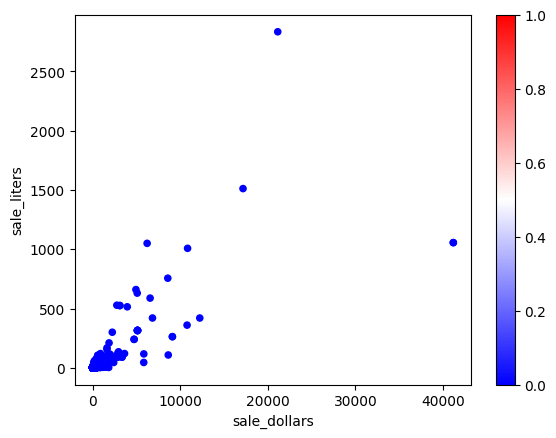

In [51]:
df_liquor.plot.scatter(x="sale_dollars", y="sale_liters", c=df_liquor["NearHoliday"], colormap="bwr")

<Axes: xlabel='sale_dollars', ylabel='sale_liters'>

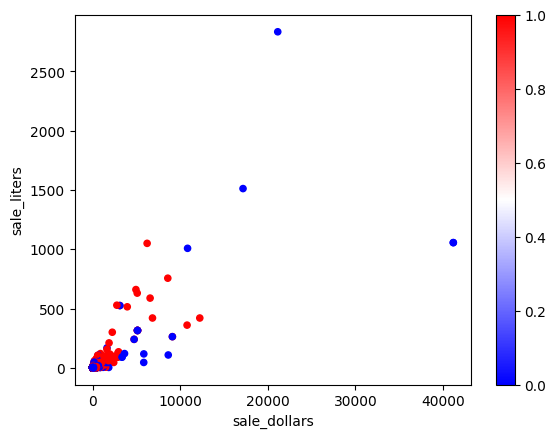

In [52]:
df_liquor.plot.scatter(x="sale_dollars", y="sale_liters", c=df_liquor["NearCollege"], colormap="bwr")

<Axes: xlabel='sale_dollars', ylabel='sale_liters'>

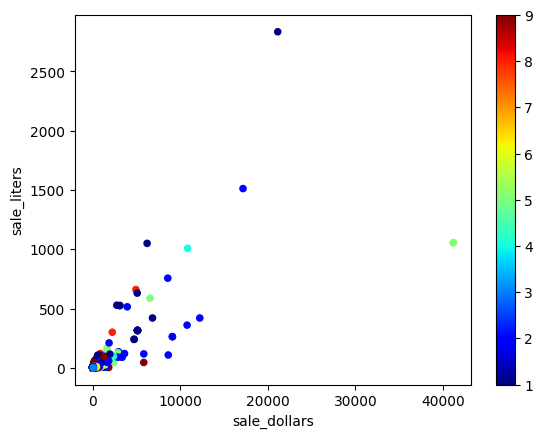

In [53]:
df_liquor.plot.scatter(x="sale_dollars", y="sale_liters", c=df_liquor["CategoryNum"], colormap="jet")

# Sources

US Holidays: https://pypi.org/project/holidays/

In [54]:

us_holidays = holidays.country_holidays('US', years=2012)
for day in us_holidays.items():
    print(day)

(datetime.date(2012, 1, 16), 'Martin Luther King Jr. Day')
(datetime.date(2012, 2, 20), "Washington's Birthday")
(datetime.date(2012, 10, 8), 'Columbus Day')
(datetime.date(2012, 1, 1), "New Year's Day")
(datetime.date(2012, 1, 2), "New Year's Day (Observed)")
(datetime.date(2012, 5, 28), 'Memorial Day')
(datetime.date(2012, 7, 4), 'Independence Day')
(datetime.date(2012, 9, 3), 'Labor Day')
(datetime.date(2012, 11, 11), 'Veterans Day')
(datetime.date(2012, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2012, 11, 22), 'Thanksgiving')
(datetime.date(2012, 12, 25), 'Christmas Day')


Iowa Colleges: https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa